# TODO
- show pinyin on top of character

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide,
    overlay_one_image_on_another, create_icon_from_slide_general_path
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [27]:
# reload configs
from configs.v010_hsk2_v1 import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])

In [28]:
truly_load_data = False
to_delete = True

# 0. Create dataframe of settings

In [29]:
# Create settings df
data_settings = fill_default_settings(data_settings)

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}{data_settings['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder)


# Create folders for audio tts
tts_zh_path = f"output/tts/{data_settings['voice_name_zh']}"
tts_en_path = f"output/tts/{data_settings['voice_name_en']}"
if not os.path.exists(tts_zh_path):
    os.mkdir(tts_zh_path)
if not os.path.exists(tts_en_path):
    os.mkdir(tts_en_path)
data_settings

{'recording_id': 'ec_csent',
 'filename_suffix': 'hsk2_v1',
 'different_file_name': 'static/hsk/HSK2_sent.csv',
 'custom_filters': [{'col_name': 'index', 'val': 0, 'operator_str': '>='},
  {'col_name': 'index', 'val': 999, 'operator_str': '<='}],
 'sort_keys': ['index'],
 'sort_asc': [True],
 'voice_name_zh': 'zh-CN-XiaoyuMultilingualNeural',
 'voice_name_en': 'en-US-AvaMultilingualNeural',
 'min_priority': 1,
 'max_priority': 4,
 'min_known_english_prompt': 1,
 'max_known_english_prompt': 6,
 'min_known_pinyin_prompt': 1,
 'max_known_pinyin_prompt': 6,
 'types_allowed': ['combo',
  'no combo',
  'two word',
  'prefix',
  'single char',
  'suffix',
  'abbreviation',
  'phrase',
  'part sent',
  'phrase_save',
  'speak_phrase',
  'saying',
  'idiom',
  'slang',
  'signs',
  'signs_uncommon',
  'sentence',
  'proper noun',
  'idiom'],
 'min_combo_quality': 6,
 'categories_allowed': None,
 'categories2_allowed': None,
 'cat1_values_allowed': None,
 'types_allowed_str': '',
 'min_adu': 1,


# 1. Load data

In [30]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('static/latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('static/latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
if len(df_dups) > 0:
    df_dups.head(20)
else:
    df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 2
(5480, 28)


# 2. Select data

In [31]:
df_vocab_lists = filter_df_to_vocab_of_interest(df_all_vocab, data_settings)
n_vocab = len(df_vocab_lists)
print(data_settings['recording_name'], n_vocab)
df_vocab_lists.head(3)

1001_ec_csent_hsk2_v1 736


,Unnamed: 0,index,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,trad,hsk3.0_pinyin,hsk3.0_def
0,0,0,啊,a,ah,你来了啊,nǐ lái le a,so you came,啊,a,particle: used in direct address and exclamati...
1,1,1,爱情,ài qíng,love,他们的爱情故事很感人,tā men de ài qíng gù shì hěn gǎn rén,their love story is very touching,愛情,àiqíng,"god, warmheartedness, affection, love_affair, ..."
2,2,2,安静,ān jìng,quiet,图书馆里很安静,tú shū guǎn lǐ hěn ān jìng,it is quiet in the library,安靜,ānjìng,"lull, quieten, quiesce, dummy, quiet down, qui..."


# 3. Create vocabulary audio recordings

In [ ]:
if data_settings['recording_id'] == '005':
    df_vocab_lists = compute_pinyin_and_create_recordings(df_vocab_lists)

start_time = time.time()
for i_row, row in df_vocab_lists.iterrows():
    print(f"{(time.time()-start_time):.1f}s, row{i_row}")
    create_tts_files_for_one_vocab_word(row, data_settings)

0.0s, row0
2.696s, zh-CN-XiaoyuMultilingualNeural, 啊
1.817s, en-US-AvaMultilingualNeural,  ah
2.993s, zh-CN-XiaoyuMultilingualNeural,  你来了啊
7.5s, row1
2.698s, zh-CN-XiaoyuMultilingualNeural, 爱情
2.145s, en-US-AvaMultilingualNeural,  love
2.135s, zh-CN-XiaoyuMultilingualNeural,  他们的爱情故事很感人
14.5s, row2
2.608s, zh-CN-XiaoyuMultilingualNeural, 安静
2.379s, en-US-AvaMultilingualNeural,  quiet
1.839s, zh-CN-XiaoyuMultilingualNeural,  图书馆里很安静
21.3s, row3
2.319s, zh-CN-XiaoyuMultilingualNeural, 安全
1.863s, en-US-AvaMultilingualNeural,  safety
2.037s, zh-CN-XiaoyuMultilingualNeural,  过马路要注意安全
27.5s, row4
1.699s, zh-CN-XiaoyuMultilingualNeural, 爱人
2.396s, en-US-AvaMultilingualNeural,  spouse
2.337s, zh-CN-XiaoyuMultilingualNeural,  他和爱人一起旅行
34.0s, row5
1.978s, zh-CN-XiaoyuMultilingualNeural, 班长
1.860s, en-US-AvaMultilingualNeural,  class leader
2.122s, zh-CN-XiaoyuMultilingualNeural,  班长帮老师收作业
39.9s, row6
1.688s, zh-CN-XiaoyuMultilingualNeural, 办
1.804s, en-US-AvaMultilingualNeural,  to handle
2.240

## 3b. Compute durations of combined audios for each vocab word

In [11]:
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {data_settings['recording_name']}, shape {df_vocab_audio_durations.shape}")
else:
    df_vocab_audio_durations = combine_audio_files_and_compute_durations(df_vocab_lists, data_settings)
    df_vocab_audio_durations.to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations['nonvocab_file_path'] = None
df_vocab_audio_durations['nonvocab_pause_ms'] = None
df_vocab_audio_durations['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations['combined'].sum()}s")
df_vocab_audio_durations.head(3)

0.39 seconds, recid1001_ec_csent_hsk1_v1, row 0, 爱
0.30 seconds, recid1001_ec_csent_hsk1_v1, row 1, 爱好
0.30 seconds, recid1001_ec_csent_hsk1_v1, row 2, 爸爸
0.31 seconds, recid1001_ec_csent_hsk1_v1, row 3, 白
0.35 seconds, recid1001_ec_csent_hsk1_v1, row 4, 八
0.32 seconds, recid1001_ec_csent_hsk1_v1, row 5, 白天
0.31 seconds, recid1001_ec_csent_hsk1_v1, row 6, 班
0.31 seconds, recid1001_ec_csent_hsk1_v1, row 7, 百
0.31 seconds, recid1001_ec_csent_hsk1_v1, row 8, 吧
0.32 seconds, recid1001_ec_csent_hsk1_v1, row 9, 半
0.32 seconds, recid1001_ec_csent_hsk1_v1, row 10, 半年
0.31 seconds, recid1001_ec_csent_hsk1_v1, row 11, 半天
0.30 seconds, recid1001_ec_csent_hsk1_v1, row 12, 帮
0.32 seconds, recid1001_ec_csent_hsk1_v1, row 13, 帮忙
0.31 seconds, recid1001_ec_csent_hsk1_v1, row 14, 包
0.31 seconds, recid1001_ec_csent_hsk1_v1, row 15, 包子
0.32 seconds, recid1001_ec_csent_hsk1_v1, row 16, 杯
0.30 seconds, recid1001_ec_csent_hsk1_v1, row 17, 杯子
0.30 seconds, recid1001_ec_csent_hsk1_v1, row 18, 北边
0.29 seconds,

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,爱,ài,love,我爱我的家人,wǒ ài wǒ de jiā rén,I love my family,1.056,0.768,1.680,0,1.556,2.824,5.504,5.503667,"HSK3.0 definition: love, like, be fond of, be ...",None,None,None
1,爱好,ài hào,hobby,她的爱好是唱歌,tā de ài hào shì chàng gē,her hobby is singing,0.888,1.080,2.088,0,1.388,2.968,6.056,6.055667,NaN,None,None,None
2,爸爸,bà ba,dad,爸爸每天送我去学校,bà ba měi tiān sòng wǒ qù xué xiào,my dad takes me to school every day,0.888,1.152,2.352,0,1.388,3.040,6.392,6.391667,"HSK3.0 definition: old man, father, papa, papp...",None,None,None


# 4. Create non-vocab audio recordings

In [12]:
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    data_settings, df_vocab_audio_durations, nonvocab_slides, project_artifacts_folder)
df_vocab_audio_durations.head(10)

Generated 欢迎观看我的普通话数据库视频 9: HSK1级音频卡片
word_list audio already generated: 这些是将在接下来的49分钟内复习的497个单词
outro audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 9: HSK1级音频卡片,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.690000,NaN,output/videos/1001_ec_csent_hsk1_v1/欢迎观看我的普通话数...,500,intro,6.690000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的49分钟内复习的497个单词,Zhèxiē shì jiàng zài jiē xiàlái de 49 fēnzhōng...,These are the 497 words that will be reviewed ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.430000,NaN,output/videos/1001_ec_csent_hsk1_v1/这些是将在接下来的4...,500,word_list,13.120000,6.690000,NaN,NaN,NaN
2,爱,ài,love,我爱我的家人,wǒ ài wǒ de jiā rén,I love my family,1.056,0.768,1.680,0.0,1.556,2.824,5.504,5.503667,"HSK3.0 definition: love, like, be fond of, be ...",None,None,None,18.623667,13.120000,13.120000,14.676000,15.944000
3,爱好,ài hào,hobby,她的爱好是唱歌,tā de ài hào shì chàng gē,her hobby is singing,0.888,1.080,2.088,0.0,1.388,2.968,6.056,6.055667,NaN,None,None,None,24.679333,18.623667,18.623667,20.011667,21.591667
4,爸爸,bà ba,dad,爸爸每天送我去学校,bà ba měi tiān sòng wǒ qù xué xiào,my dad takes me to school every day,0.888,1.152,2.352,0.0,1.388,3.040,6.392,6.391667,"HSK3.0 definition: old man, father, papa, papp...",None,None,None,31.071000,24.679333,24.679333,26.067333,27.719333
5,白,bái,white,这件衣服是白颜色的,zhè jiàn yī fú shì bái yán sè de,this piece of clothing is white,0.888,0.912,2.280,0.0,1.388,2.800,6.080,6.079667,"HSK3.0 definition: white, clear, pure, plain, ...",None,None,None,37.150667,31.071000,31.071000,32.459000,33.871000
6,八,bā,eight,我家有八口人,wǒ jiā yǒu bā kǒu rén,there are eight people in my family,0.888,0.792,1.800,0.0,1.388,2.680,5.480,5.479667,HSK3.0 definition: det.: eight,None,None,None,42.630333,37.150667,37.150667,38.538667,39.830667
7,白天,bái tiān,daytime,白天很热晚上很凉快,bái tiān hěn rè wǎn shàng hěn liáng kuai,it is hot during the day and cool at night,1.008,1.056,2.592,0.0,1.508,3.064,6.656,6.655667,"HSK3.0 definition: daytime, during the day, da...",None,None,None,49.286000,42.630333,42.630333,44.138333,45.694333
8,班,bān,class,我们班有三十个学生,wǒ men bān yǒu sān shí gè xué shēng,our class has thirty students,1.128,0.744,2.064,0.0,1.628,2.872,5.936,5.935667,HSK3.0 definition: m.[event],None,None,None,55.221667,49.286000,49.286000,50.914000,52.158000
9,百,bǎi,hundred,这里有一百本书,zhè lǐ yǒu yī bǎi běn shū,there are one hundred books here,0.984,0.840,1.800,0.0,1.484,2.824,5.624,5.623667,"HSK3.0 definition: cent, centum, century, hund...",None,None,None,60.845333,55.221667,55.221667,56.705667,58.045667


# 5. Combine individual vocab into final audio recording

In [13]:
create_final_audio_from_each_word_and_nonvocab(df_vocab_audio_durations, project_artifacts_folder, data_settings)

49.54s, output/videos/1001_ec_csent_hsk1_v1/audio.mp3


# 6. Create images for video

In [14]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    try:
        df_vocab_audio_durations = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{data_settings['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {data_settings['recording_name']}, please run the cell above to generate audio durations.")
df_vocab_audio_durations.head()

1001_ec_csent_hsk1_v1 loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 9: HSK1级音频卡片,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.690000,NaN,output/videos/1001_ec_csent_hsk1_v1/欢迎观看我的普通话数...,500.0,intro,6.690000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的49分钟内复习的497个单词,Zhèxiē shì jiàng zài jiē xiàlái de 49 fēnzhōng...,These are the 497 words that will be reviewed ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.430000,NaN,output/videos/1001_ec_csent_hsk1_v1/这些是将在接下来的4...,500.0,word_list,13.120000,6.690000,NaN,NaN,NaN
2,爱,ài,love,我爱我的家人,wǒ ài wǒ de jiā rén,I love my family,1.056,0.768,1.680,0.0,1.556,2.824,5.504,5.503667,"HSK3.0 definition: love, like, be fond of, be ...",NaN,NaN,NaN,18.623667,13.120000,13.120000,14.676000,15.944000
3,爱好,ài hào,hobby,她的爱好是唱歌,tā de ài hào shì chàng gē,her hobby is singing,0.888,1.080,2.088,0.0,1.388,2.968,6.056,6.055667,NaN,NaN,NaN,NaN,24.679333,18.623667,18.623667,20.011667,21.591667
4,爸爸,bà ba,dad,爸爸每天送我去学校,bà ba měi tiān sòng wǒ qù xué xiào,my dad takes me to school every day,0.888,1.152,2.352,0.0,1.388,3.040,6.392,6.391667,"HSK3.0 definition: old man, father, papa, papp...",NaN,NaN,NaN,31.071000,24.679333,24.679333,26.067333,27.719333


## 6a. Vocab words

Drawing 0: 爱
Drawing 1: 爱好
Drawing 2: 爸爸
reduced font size to 22
reduced font size to 20
reduced font size to 18
Drawing 3: 白
Drawing 4: 八
Drawing 5: 白天
Drawing 6: 班
Drawing 7: 百
Drawing 8: 吧
Drawing 9: 半
Drawing 10: 半年
Drawing 11: 半天
Drawing 12: 帮
Drawing 13: 帮忙
reduced font size to 22
Drawing 14: 包
reduced font size to 22
reduced font size to 20
Drawing 15: 包子
Drawing 16: 杯
Drawing 17: 杯子
Drawing 18: 北边
Drawing 19: 本
Drawing 20: 北京
Drawing 21: 北
Drawing 22: 本子
Drawing 23: 别
Drawing 24: 别的
Drawing 25: 别人
Drawing 26: 病
Drawing 27: 病人
Drawing 28: 比
Drawing 29: 不大
Drawing 30: 不客气
Drawing 31: 不用
Drawing 32: 菜
Drawing 33: 不对
Drawing 34: 差
Drawing 35: 不
Drawing 36: 茶
Drawing 37: 常常
reduced font size to 22
reduced font size to 20
reduced font size to 18
Drawing 38: 常
Drawing 39: 车
Drawing 40: 唱歌
Drawing 41: 车上
Drawing 42: 车票
Drawing 43: 唱
Drawing 44: 吃
reduced font size to 22
reduced font size to 20
reduced font size to 18
reduced font size to 16
reduced font size to 14
reduced font size to 


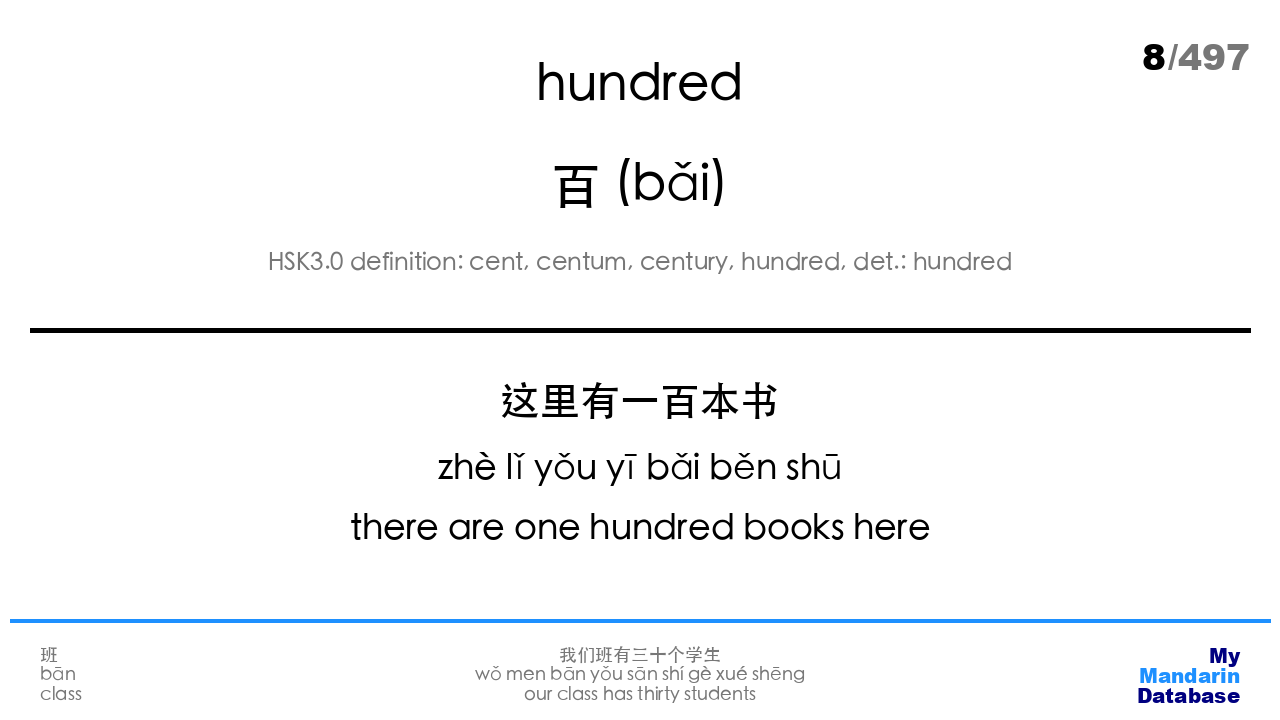

In [15]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{project_artifacts_folder}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_vocab_audio_durations.dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab, word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if data_settings['recording_id'] in ['013', 'ceword_csent', 'ceword_components_cesent', 'ceword_components_csent', 'ec_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(data_settings['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[23].display_in_notebook()

# 7. Create non-vocab slides


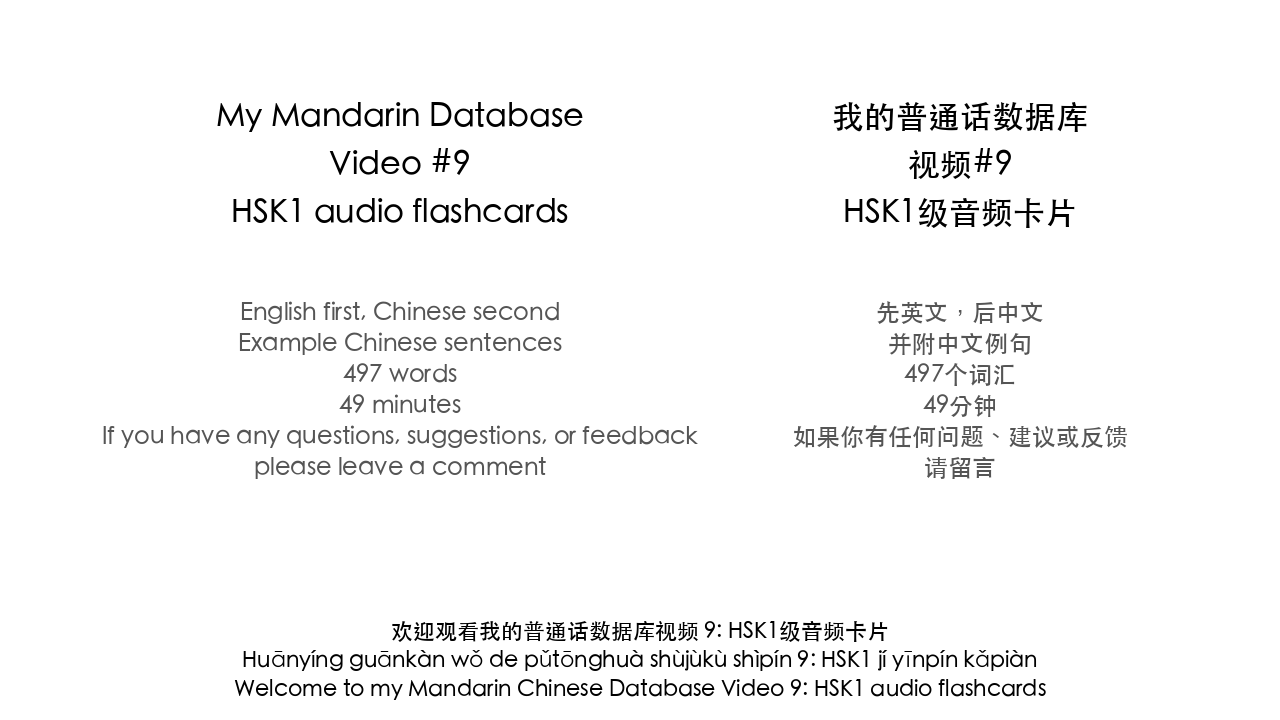

In [17]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables)
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()

"half a year" reduced font size to 8
"half a day" reduced font size to 8
"bāng máng" reduced font size to 8
"bāng máng" reduced font size to 6
"do a favor" reduced font size to 8
"steamed bun" reduced font size to 8
"steamed bun" reduced font size to 6
"north side" reduced font size to 8
"measure word for books" reduced font size to 8
"measure word for books" reduced font size to 6
"measure word for books" reduced font size to 4
"measure word for books" reduced font size to 2
"notebook" reduced font size to 8
"other people" reduced font size to 8
"other people" reduced font size to 6
"to compare" reduced font size to 8
"to compare" reduced font size to 6
"not very big" reduced font size to 8
"not very big" reduced font size to 6
"you are welcome" reduced font size to 8
"you are welcome" reduced font size to 6
"you are welcome" reduced font size to 4
"not correct" reduced font size to 8
"bad or lacking" reduced font size to 8
"bad or lacking" reduced font size to 6
"cháng cháng" reduced


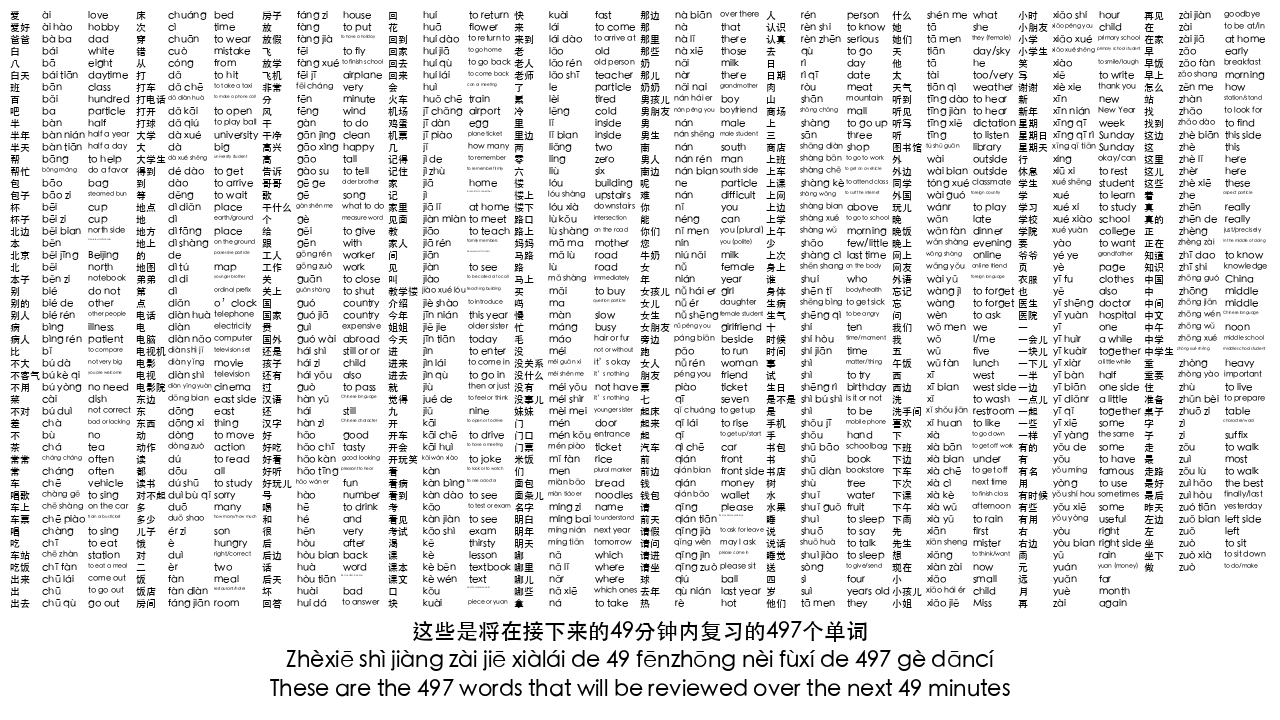

In [18]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()

"half a year" reduced font size to 8
"half a day" reduced font size to 8
"bāng máng" reduced font size to 8
"bāng máng" reduced font size to 6
"do a favor" reduced font size to 8
"steamed bun" reduced font size to 8
"steamed bun" reduced font size to 6
"north side" reduced font size to 8
"measure word for books" reduced font size to 8
"measure word for books" reduced font size to 6
"measure word for books" reduced font size to 4
"measure word for books" reduced font size to 2
"notebook" reduced font size to 8
"other people" reduced font size to 8
"other people" reduced font size to 6
"to compare" reduced font size to 8
"to compare" reduced font size to 6
"not very big" reduced font size to 8
"not very big" reduced font size to 6
"you are welcome" reduced font size to 8
"you are welcome" reduced font size to 6
"you are welcome" reduced font size to 4
"not correct" reduced font size to 8
"bad or lacking" reduced font size to 8
"bad or lacking" reduced font size to 6
"cháng cháng" reduced


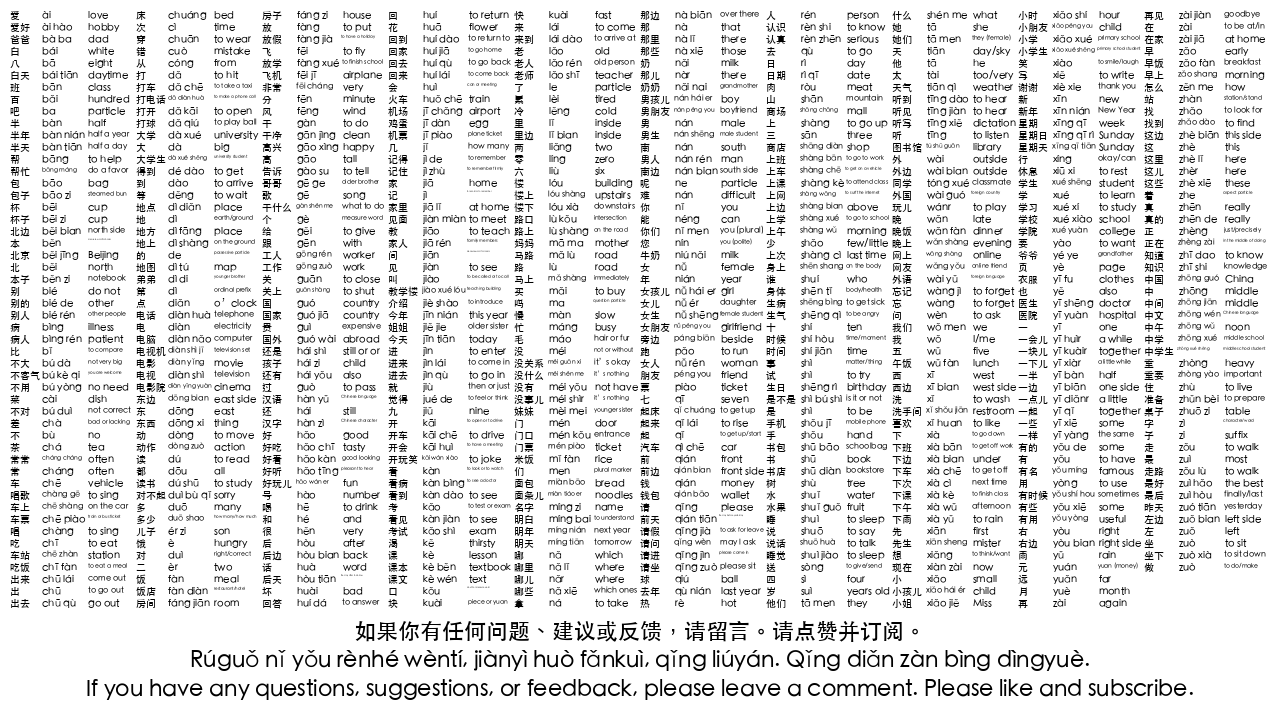

In [19]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


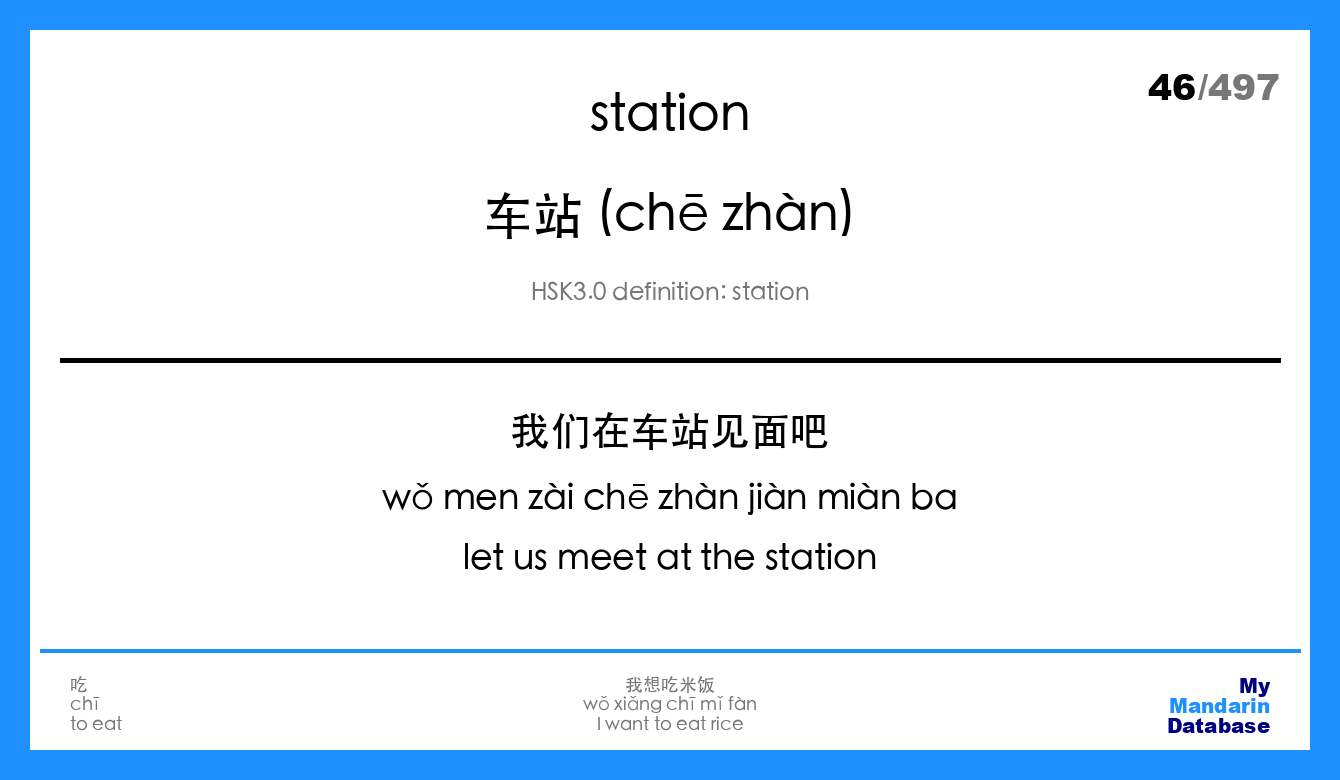

In [20]:
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()


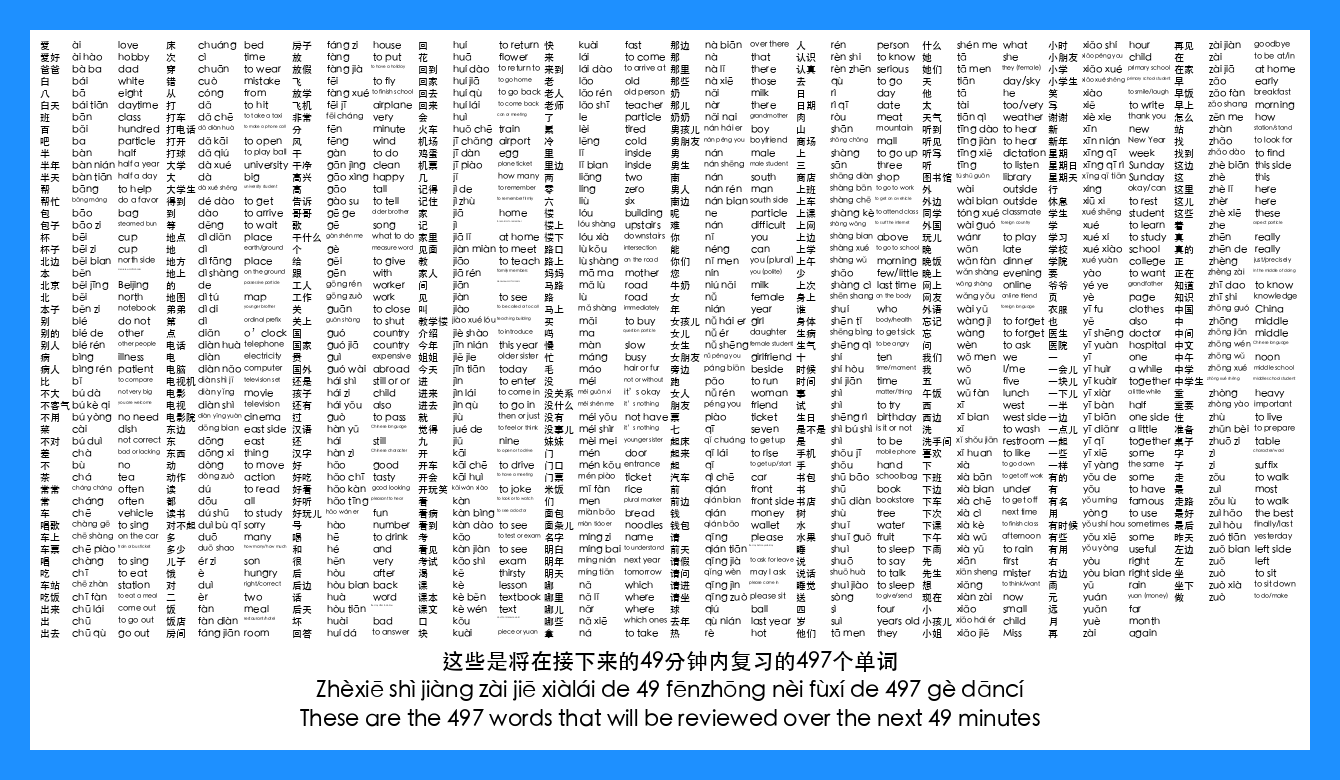

In [21]:
path_to_bottom_image = f"{project_artifacts_folder}/word_list.png"
img = create_icon_from_slide_general_path(icon_configs, video_configs, path_to_bottom_image)
img.save(f'{project_artifacts_folder}/icon2.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon2.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [22]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 1494
audio: 2987.420s, video: 2987.354s; difference: 0.066s
MoviePy - Building video output/videos/1001_ec_csent_hsk1_v1/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos/1001_ec_csent_hsk1_v1/video.mp4



MoviePy - Done !
MoviePy - video ready output/videos/1001_ec_csent_hsk1_v1/video.mp4
